# Adopt a Pet

You are in charge of an animal shelter and you want to predict if the animals you have in your possession can be adopted within 30 days or not.

The dataset at your disposal contains different information about the animals in the shelter: data about the breed or color, data about a cost, data about its health. You even have a short description written by the former owner and a picture of the animal.

We provide you only with the train part and a small test subset so that you can test the whole process.

<div class="alert-block alert-danger">
Deadline: Jannuary 15, 2022.
<br>
<br>
You must submit a zip archive to LMS that contains 3 documents:

- A pdf report that outlines the various stages of your work. You will insist on the different hyperparameters of your treatment and for each of them, you will specify on which ranges of values you have tested them. This report will also contain the precision obtained on the train set and on the test set.

- the executable notebook containing only the chosen hyper-parameters and not their research. You will leave in this one the execution traces.

- A ".joblib" file so that we can execute your code. Of course, the test dataset will be modified and only the predict function of the pipeline will be executed.
<br>
<br> 
The final grade will be based on the quality of the prediction (accuracy score) for 25% and the quality of the work for 75%.
</div>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-train-data" data-toc-modified-id="Load-train-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load train data</a></span><ul class="toc-item"><li><span><a href="#Load-the-images" data-toc-modified-id="Load-the-images-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Load the images</a></span></li><li><span><a href="#Compute-SIFT-detector-and-descriptors-for-one-image" data-toc-modified-id="Compute-SIFT-detector-and-descriptors-for-one-image-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Compute SIFT detector and descriptors for one image</a></span></li><li><span><a href="#Extract-features-and-build-BOFs" data-toc-modified-id="Extract-features-and-build-BOFs-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Extract features and build BOFs</a></span></li></ul></li><li><span><a href="#Build-a-basic-model" data-toc-modified-id="Build-a-basic-model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Build a basic model</a></span></li><li><span><a href="#Evaluation-of-the-model" data-toc-modified-id="Evaluation-of-the-model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Evaluation of the model</a></span></li></ul></div>

In [1]:
import os
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
%matplotlib inline

## Load train data

In [3]:
path = "https://www.i3s.unice.fr/~riveill/dataset/petfinder-adoption-prediction/"

In [4]:
breeds = pd.read_csv(path+'breed_labels.csv')
colors = pd.read_csv(path+'color_labels.csv')
states = pd.read_csv(path+'state_labels.csv')

train = pd.read_csv(path+'train.csv')

train['dataset_type'] = 'train'

In [5]:
len(train)

8168

In [6]:
# In this example notebook, we will only work with a small part of the dataset
N = 10
train = train[:N]

In [7]:
if 'dataset_type' in train.columns:
    train = train.drop(labels='dataset_type', axis=1)
train.columns

Index(['Type', 'Age', 'Gender', 'Color1', 'Color2', 'Color3', 'MaturitySize',
       'FurLength', 'Vaccinated', 'Dewormed', 'Sterilized', 'Health', 'Fee',
       'Description', 'Images', 'Breed', 'target'],
      dtype='object')

In [8]:
y_train = train['target']
X_train = train.drop(['target'], axis=1)
X_train.head()

,Type,Age,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Fee,Description,Images,Breed
0,Cat,12.0,Female,White,Unknown,Unknown,Medium,Yes,Unknown,Unknown,Unknown,Healthy,0.0,We got Luna when she was a kitten in Feb 15'. ...,880e13787-4.jpg,Domestic_Short_Hair
1,Cat,4.0,Male,Golden,White,Unknown,Medium,Yes,No,Yes,No,Healthy,0.0,Ginger Boy was found starving and hungry so I ...,7abe9a0a1-2.jpg,Domestic_Short_Hair
2,Cat,12.0,Female,Black,Golden,White,Medium,No,No,No,No,Healthy,0.0,An indoor cat with nice green/ yellowish eyes....,605d07d33-5.jpg,Domestic_Medium_Hair
3,Dog,60.0,Male,Black,Gray,White,Medium,No,Yes,Unknown,Unknown,Healthy,0.0,My dog name called boo. He is a male. I feedin...,7ed568ab9-1.jpg,Schnauzer
4,Cat,36.0,Female,Cream,Gray,White,Large,No,No,No,Yes,Healthy,0.0,"1) Foxy is a stray cat which I feed regularly,...",8969b314b-5.jpg,Siamese


In [9]:
y_train.head()

0     True
1    False
2     True
3    False
4     True
Name: target, dtype: bool

In [10]:
cat_cols = ['Type', 'Gender', 'Breed', 'Color1', 'Color2', 'Color3', 
       'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health']
num_cols = ['Age', 'Fee']
txt_cols = ['Description']
img_cols = ['Images']

### Load the images

In [11]:
# Build the image list of the training set 
img_dir = "train_images/"
X_train['Images'] = [path+img_dir+img for img in train['Images']]

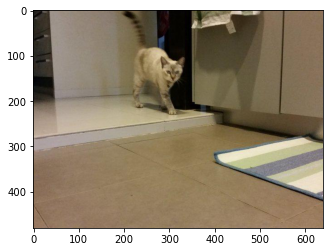

In [12]:
from skimage import io

# Read the first image of the list
img = io.imread(X_train['Images'][0])
# have a look to the image
plt.imshow(img)

### Compute SIFT detector and descriptors for one image

In [13]:
# convert the image to grey levels 
import cv2

gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

In [14]:
# compute SIFT detector and descriptors
sift = cv2.SIFT_create()
kp,des = sift.detectAndCompute(gray,None)

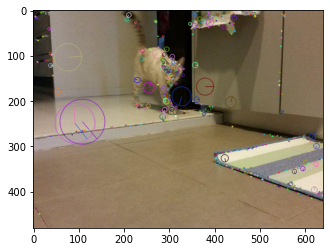

In [15]:
# plot image and descriptors
cv2.drawKeypoints(img,kp,img,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img)

### Extract features and build BOFs

In [16]:
# First step, extract the SIFTs of each image
# Be carefull: very long process

def extract_SIFT(img_lst):
    nbSIFTs = 0    # Nomber of SIFTs
    SIFTs = []  # List of SIFTs descriptors 
    #dimImgs = []   # Nb of descriptors associated to each images

    for pathImg in tqdm(img_lst, position=0, leave=True): 
        img = io.imread(pathImg)
        if len(img.shape)==2: # this is a grey level image
            gray = img
        else: # we expect the image to be a RGB image or RGBA
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        sift = cv2.SIFT_create()
        kp, des = sift.detectAndCompute(gray, None)
        if len(kp) == 0 and img.shape[2]==4: #some images are mask on alpha channel: we thus extract this channel if not kpts have been detected
            gray = img[:,:,3]
            sift = cv2.SIFT_create()
            kp, des = sift.detectAndCompute(gray, None)
        
        nbSIFTs += des.shape[0]
        SIFTs.append(des)
        #dimImgs.append(des.shape[0])
    return nbSIFTs, SIFTs#, dimImgs

In [17]:
nbSIFTs, SIFTs = extract_SIFT(X_train['Images'])
print('nbSifts: ', nbSIFTs)

100%|██████████| 10/10 [00:00<00:00, 15.12it/s]

nbSifts:  4179


In [18]:
# Step 2: clusterize the SIFT
from sklearn.cluster import MiniBatchKMeans

def clusterize(SIFTs, nb_img_features=5, verbose=False):
    clusterizer = MiniBatchKMeans(n_clusters=nb_img_features)   # nb_img_features is a hyperparameter
    # learning of the clustering
    flat_list = SIFTs[0]
    for des in SIFTs[1:]:
        flat_list = np.concatenate((flat_list, des))
        if verbose:
            print("shape:", des.shape, flat_list.shape)
    clusterizer.fit(flat_list)
    # we now know the label of each SIFT descriptor
    return clusterizer

In [19]:
clusterizer = clusterize(SIFTs, verbose=True)

shape: (75, 128) (466, 128)
shape: (117, 128) (583, 128)
shape: (302, 128) (885, 128)
shape: (138, 128) (1023, 128)
shape: (655, 128) (1678, 128)
shape: (1306, 128) (2984, 128)
shape: (461, 128) (3445, 128)
shape: (622, 128) (4067, 128)
shape: (112, 128) (4179, 128)


In [20]:
# Step 3: build the BOW representation of each images (i.e. construction of the BOFs)

def build_BOFs(SIFTs, clusterizer, verbose=False):
    ok, nok = 0, 0
    #BOF initialization
    nb_img_features = clusterizer.get_params()['n_clusters']
    BOFs = np.empty(shape=(0, nb_img_features), dtype=int)

    # Build label list
    flat_list = SIFTs[0]
    for des in SIFTs[1:]:
        flat_list = np.concatenate((flat_list, des))
        if verbose:
            print("shape:", des.shape, flat_list.shape)
    labels = clusterizer.predict(flat_list)

    # loop on images
    i = 0 # index for the loop on SIFTs
    for des in SIFTs:
        #initialisation of the bof for the current image
        tmpBof = np.array([0]*nb_img_features)
        j = 0
        # for every SIFT of the current image:
        nbs = des.shape[0]
        while j < nbs:
            tmpBof[labels[i]] += 1
            j+=1
            i+=1
        BOFs = np.concatenate((BOFs, tmpBof.reshape(1,-1)), axis=0)
    if verbose:
        print("BOFs : ", BOFs)
    
    return BOFs

In [21]:
BOFs = build_BOFs(SIFTs, clusterizer, verbose=True)
BOFs.shape

shape: (75, 128) (466, 128)
shape: (117, 128) (583, 128)
shape: (302, 128) (885, 128)
shape: (138, 128) (1023, 128)
shape: (655, 128) (1678, 128)
shape: (1306, 128) (2984, 128)
shape: (461, 128) (3445, 128)
shape: (622, 128) (4067, 128)
shape: (112, 128) (4179, 128)
BOFs :  [[ 37 156 129  40  29]
 [ 12  14  14  25  10]
 [ 29  22  22  26  18]
 [ 38  91  52  85  36]
 [ 28  32  44  21  13]
 [165  70  78 223 119]
 [341 177 170 395 223]
 [ 90  50  92 149  80]
 [162  71  62 222 105]
 [  6  35  42  19  10]]


(10, 5)

In [29]:
from sklearn.base import BaseEstimator,TransformerMixin

def list_comparaison(l1, l2):
    if not l1 is None \
        and not l2 is None \
        and len(l1)==len(l2) \
        and len(l1)==sum([1 for i,j in zip(l1, l2) if i==j]):
        return True
    return False
    
class BOF_extractor(BaseEstimator,TransformerMixin): 
    X = None
    SIFTs = None
    nbSIFTs = 0
    
    def __init__(self, nb_img_features=10, verbose=False):
        self.nb_img_features = nb_img_features
        self.verbose = verbose
        self.path = path
        if self.verbose:
            print("BOF.init()")
        
    def fit(self, X, y=None):
        if self.verbose:
            print("BOF.fit()")
        if list_comparaison(X, self.X):
            SIFTs = self.SIFTs 
            nbSIFTs = self.nbSIFTs
        else:
            if self.verbose:
                print("extract_SIFT")
            nbSIFTs, SIFTs = extract_SIFT(X)
        self.X = X
        self.SIFTs = SIFTs 
        self.nbSIFTs = nbSIFTs
        self.clusterizer = clusterize(SIFTs, self.nb_img_features, self.verbose)
        
    def transform(self, X, y=None):
        if self.verbose:
            print("BOF.transform()")
        if list_comparaison(X, self.X):
            SIFTs = self.SIFTs 
            nbSIFTs = self.nbSIFTs
        else:
            if self.verbose:
                print("extract_SIFT")
            nbSIFTs, SIFTs = extract_SIFT(X)

        if self.verbose:
            print("nbSIFTs:", nbSIFTs)
        return build_BOFs(SIFTs, self.clusterizer, self.verbose)
    
    def fit_transform(self, X, y=None):
        if self.verbose:
            print("BOF.fit_transform()")
        if list_comparaison(X, self.X):
            SIFTs = self.SIFTs 
            nbSIFTs = self.nbSIFTs
        else:
            if self.verbose:
                print("extract_SIFT")
            nbSIFTs, SIFTs = extract_SIFT(X)
        self.X = X
        self.SIFTs = SIFTs 
        self.nbSIFTs = nbSIFTs
        self.clusterizer = clusterize(SIFTs, self.nb_img_features, self.verbose)
        return build_BOFs(SIFTs, self.clusterizer, self.verbose)

In [30]:
test_BOF_extractor = BOF_extractor(nb_img_features=5, verbose=True)

BOF.init()


In [31]:
test_BOF_extractor.fit(X_train['Images'])

 10%|█         | 1/10 [00:00<00:01,  6.65it/s]

BOF.fit()
extract_SIFT


100%|██████████| 10/10 [00:00<00:00, 14.67it/s]

shape: (75, 128) (466, 128)
shape: (117, 128) (583, 128)
shape: (302, 128) (885, 128)
shape: (138, 128) (1023, 128)
shape: (655, 128) (1678, 128)
shape: (1306, 128) (2984, 128)
shape: (461, 128) (3445, 128)
shape: (622, 128) (4067, 128)
shape: (112, 128) (4179, 128)


In [32]:
BOFs = test_BOF_extractor.transform(X_train['Images'])
BOFs.shape

BOF.transform()
nbSIFTs: 4179
shape: (75, 128) (466, 128)
shape: (117, 128) (583, 128)
shape: (302, 128) (885, 128)
shape: (138, 128) (1023, 128)
shape: (655, 128) (1678, 128)
shape: (1306, 128) (2984, 128)
shape: (461, 128) (3445, 128)
shape: (622, 128) (4067, 128)
shape: (112, 128) (4179, 128)
BOFs :  [[ 46  36  51 138 120]
 [ 24  14   2  13  22]
 [ 29  19  33  13  23]
 [ 92  51  13  58  88]
 [ 21  17  27  23  50]
 [222 188  98  74  73]
 [395 381 189 164 177]
 [116  99  54 113  79]
 [223 162  96  52  89]
 [ 24   9   6  29  44]]


(10, 5)

In [33]:
BOFs = test_BOF_extractor.fit_transform(X_train['Images'])
BOFs.shape

BOF.fit_transform()
shape: (75, 128) (466, 128)
shape: (117, 128) (583, 128)
shape: (302, 128) (885, 128)
shape: (138, 128) (1023, 128)
shape: (655, 128) (1678, 128)
shape: (1306, 128) (2984, 128)
shape: (461, 128) (3445, 128)
shape: (622, 128) (4067, 128)
shape: (112, 128) (4179, 128)
shape: (75, 128) (466, 128)
shape: (117, 128) (583, 128)
shape: (302, 128) (885, 128)
shape: (138, 128) (1023, 128)
shape: (655, 128) (1678, 128)
shape: (1306, 128) (2984, 128)
shape: (461, 128) (3445, 128)
shape: (622, 128) (4067, 128)
shape: (112, 128) (4179, 128)
BOFs :  [[ 60  30  49 225  27]
 [ 26   9   3  25  12]
 [ 27  11  30  24  25]
 [ 96  37  21 109  39]
 [ 27  13  24  57  17]
 [242 104  96  94 119]
 [435 262 174 198 237]
 [154  95  44 110  58]
 [240 115  97  75  95]
 [ 26   5   8  65   8]]


(10, 5)

In [34]:
test = pd.read_csv(path+"test.csv")
y_test = test['target']
X_test = test.drop(['target'], axis=1)

img_dir = "test_images/"
X_test['Images'] = [path+img_dir+img for img in test['Images']]
len(X_test)

250

In [35]:
BOFs = test_BOF_extractor.transform(X_test['Images'])
BOFs.shape

  1%|          | 2/250 [00:00<00:23, 10.78it/s]

BOF.transform()
extract_SIFT


100%|██████████| 250/250 [00:19<00:00, 13.00it/s]


nbSIFTs: 177122
shape: (2011, 128) (2350, 128)
shape: (913, 128) (3263, 128)
shape: (1712, 128) (4975, 128)
shape: (2479, 128) (7454, 128)
shape: (332, 128) (7786, 128)
shape: (372, 128) (8158, 128)
shape: (329, 128) (8487, 128)
shape: (230, 128) (8717, 128)
shape: (983, 128) (9700, 128)
shape: (296, 128) (9996, 128)
shape: (430, 128) (10426, 128)
shape: (319, 128) (10745, 128)
shape: (816, 128) (11561, 128)
shape: (235, 128) (11796, 128)
shape: (1316, 128) (13112, 128)
shape: (1175, 128) (14287, 128)
shape: (417, 128) (14704, 128)
shape: (184, 128) (14888, 128)
shape: (243, 128) (15131, 128)
shape: (333, 128) (15464, 128)
shape: (936, 128) (16400, 128)
shape: (548, 128) (16948, 128)
shape: (1096, 128) (18044, 128)
shape: (730, 128) (18774, 128)
shape: (383, 128) (19157, 128)
shape: (577, 128) (19734, 128)
shape: (1348, 128) (21082, 128)
shape: (855, 128) (21937, 128)
shape: (691, 128) (22628, 128)
shape: (159, 128) (22787, 128)
shape: (488, 128) (23275, 128)
shape: (615, 128) (23890, 

(250, 5)

## Build a basic model

There are much more interesting things in the dataset and I'm going to explore them, but for now let's build a simple model as a baseline.

In [36]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")
numerical_preprocessor = StandardScaler()
text_preprocessor = CountVectorizer()
image_preprocessor = BOF_extractor(nb_img_features=3, verbose=False)

preprocessor = ColumnTransformer([
    ("categorical encoding", categorical_preprocessor, cat_cols),
    ("numerical encoding", numerical_preprocessor, num_cols),
    ("text encoding", text_preprocessor, 'Description'),
    ("image encoding", image_preprocessor, 'Images'),
])

classifier = LogisticRegression()

model = make_pipeline(preprocessor, classifier)

In [37]:
model.fit(X_train, y_train)
y_pred = model.predict(X_train)
accuracy_score(y_train, y_pred)

100%|██████████| 10/10 [00:00<00:00, 15.84it/s]


1.0

In [38]:
# Save the model
from joblib import dump, load

dump(model, 'michel.joblib') # Put your name as a model name

['michel.joblib']

## Evaluation of the model

<div class="alert alert-block alert-danger">
We will only execute the following cells.
</div>

In [39]:
test = pd.read_csv(path+"test.csv")

y_test = test['target']
X_test = test.drop(['target'], axis=1)

img_dir = "test_images/"
X_test['Images'] = [path+img_dir+img for img in test['Images']]
print("Test size:", len(X_test))

model = load('michel.joblib') 
y_pred = model.predict(X_train)
print("ACC on train", accuracy_score(y_train, y_pred))
y_pred = model.predict(X_test)
print("ACC on test", accuracy_score(y_test, y_pred))

  0%|          | 0/250 [00:00<?, ?it/s]

Test size: 250
ACC on train 1.0


100%|██████████| 250/250 [00:19<00:00, 12.52it/s]


ACC on test 0.524
